# Projet n°6 : Classifiez automatiquement des biens de consommation

## Import des librairies principales

In [372]:
import pandas as pd
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import nltk
import random as rn
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
sns.set_context('talk')

In [373]:
# Configuration de l'accélaration TPU

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.14.96.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.14.96.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [375]:
# Configuration de l'environnement google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [376]:
# Reproductibilité des résultats

os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(0)
rn.seed(1)
tf.random.set_seed(2)

## Chargement des données 

In [377]:
# Chargement du dataset

df = pd.read_csv('/content/drive/MyDrive/colab/P6/Flipkart/flipkart_com-ecommerce_sample_1050.csv', index_col='uniq_id')

### Exploration du jeux de données

In [378]:
df.head()

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
uniq_id,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 55b85ea15a1536d46b7190ad6fff8ce7 to f2f027ad6a6df617c9f125173da71e44
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   crawl_timestamp          1050 non-null   object 
 1   product_url              1050 non-null   object 
 2   product_name             1050 non-null   object 
 3   product_category_tree    1050 non-null   object 
 4   pid                      1050 non-null   object 
 5   retail_price             1049 non-null   float64
 6   discounted_price         1049 non-null   float64
 7   image                    1050 non-null   object 
 8   is_FK_Advantage_product  1050 non-null   bool   
 9   description              1050 non-null   object 
 10  product_rating           1050 non-null   object 
 11  overall_rating           1050 non-null   object 
 12  brand                    712 non-null    object 
 13  product_specifications  

In [380]:
df.describe(include='all') # include='all' permet d'afficher les données de 
                           # types catégorielles

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1049.000000,1049.000000,1050,1050,1050,1050,1050,712,1049
unique,149,1050,1050,642,1050,NaN,NaN,1050,2,1050,27,27,490,984
top,2015-12-01 12:40:44 +0000,http://www.flipkart.com/ctw-ganpati-bapa-moriy...,RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORT...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",RTRECC5QVCHZ4JT5,NaN,NaN,be0e65c6d8c2cc8cb913b36aa4168cf0.jpg,False,Nexus NX_7668 Analog Watch - For Men - Buy Ne...,No rating available,No rating available,Lapguard,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,150,1,1,56,1,NaN,NaN,1,993,1,889,889,11,22
mean,NaN,NaN,NaN,NaN,NaN,2186.197331,1584.527169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,7639.229411,7475.099680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,35.000000,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,555.000000,340.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,999.000000,600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1999.000000,1199.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [381]:
round(df.isnull().sum() / len(df), 2)

# 32% des marques sont manquantes (brand)

crawl_timestamp            0.00
product_url                0.00
product_name               0.00
product_category_tree      0.00
pid                        0.00
retail_price               0.00
discounted_price           0.00
image                      0.00
is_FK_Advantage_product    0.00
description                0.00
product_rating             0.00
overall_rating             0.00
brand                      0.32
product_specifications     0.00
dtype: float64

## Nettoyage du dataset

In [382]:
# Modification du type de données (vers un format datetime)

df['crawl_timestamp'] = pd.to_datetime(df['crawl_timestamp'])

### Création des labels

Je vais utiliser les catégories encoder sous la variable **'product_category_tree',** afin de créer les labels. Les instances de cette variable sont enregistrées de la manière  suivante : *catégorie / sous-catégorie 1 / sous-catégorie 2 / sous-catégorie 3* ... Je vais explorer les données afin de déterminer quels labels extraire de cette variable

In [383]:
df['product_category_tree'][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [384]:
# Nettoyaqe 

df['product_category_tree_clean'] = df['product_category_tree'].str.\
replace('[', '', regex=True).replace('"', '', regex=True).str.split('>>')

# Extraction de la catégorie racine 

df['product_category_first_elem'] = df['product_category_tree_clean']\
.apply(lambda x : x[0])


In [385]:
display(df['product_category_first_elem'])

print('\n-----------\n')

display(df['product_category_first_elem'].value_counts())

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    Home Furnishing 
7b72c92c2f6c40268628ec5f14c6d590          Baby Care 
64d5d4a258243731dc7bbb1eef49ad74          Baby Care 
d4684dcdc759dd9cdf41504698d737d8    Home Furnishing 
6325b6870c54cd47be6ebfbffa620ec7    Home Furnishing 
                                          ...       
958f54f4c46b53c8a0a9b8167d9140bc          Baby Care 
fd6cbcc22efb6b761bd564c28928483c          Baby Care 
5912e037d12774bb73a2048f35a00009          Baby Care 
c3edc504d1b4f0ba6224fa53a43a7ad6          Baby Care 
f2f027ad6a6df617c9f125173da71e44          Baby Care 
Name: product_category_first_elem, Length: 1050, dtype: object


-----------



Kitchen & Dining               150
Baby Care                      150
Beauty and Personal Care       150
Computers                      150
Home Furnishing                150
Watches                        150
Home Decor & Festive Needs     150
Name: product_category_first_elem, dtype: int64

In [386]:
# Extraction de la catégorie racine + la sous-catégorie 1

df['product_category_first_elem_second_elem'] = df['product_category_tree_clean'].apply(lambda x : x[:2])

In [387]:
display(df['product_category_first_elem_second_elem'])

print('\n-----------\n')

display(df['product_category_first_elem_second_elem'].value_counts())

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    [Home Furnishing ,  Curtains & Accessories ]
7b72c92c2f6c40268628ec5f14c6d590                [Baby Care ,  Baby Bath & Skin ]
64d5d4a258243731dc7bbb1eef49ad74                [Baby Care ,  Baby Bath & Skin ]
d4684dcdc759dd9cdf41504698d737d8                 [Home Furnishing ,  Bed Linen ]
6325b6870c54cd47be6ebfbffa620ec7                 [Home Furnishing ,  Bed Linen ]
                                                        ...                     
958f54f4c46b53c8a0a9b8167d9140bc               [Baby Care ,  Baby & Kids Gifts ]
fd6cbcc22efb6b761bd564c28928483c               [Baby Care ,  Baby & Kids Gifts ]
5912e037d12774bb73a2048f35a00009               [Baby Care ,  Baby & Kids Gifts ]
c3edc504d1b4f0ba6224fa53a43a7ad6               [Baby Care ,  Baby & Kids Gifts ]
f2f027ad6a6df617c9f125173da71e44               [Baby Care ,  Baby & Kids Gifts ]
Name: product_category_first_elem_second_elem, Length: 1050, dtype: object


-----------



TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Watches ,  Wrist Watches ]                              149
[Computers ,  Laptop Accessories ]                        87
[Baby Care ,  Infant Wear ]                               84
[Kitchen & Dining ,  Coffee Mugs ]                        74
[Home Decor & Festive Needs ,  Showpieces ]               71
                                                        ... 
[Home Furnishing ,  JMD Home Furnishing ]                  1
[Home Furnishing ,  Kripa's Home Furnishing ]              1
[Home Decor & Festive Needs ,  Candles & Fragrances ]      1
[Watches ,  Clocks ]                                       1
[Beauty and Personal Care ,  Beauty Accessories ]          1
Name: product_category_first_elem_second_elem, Length: 63, dtype: int64

La **catégorie racine** permet de découper les données en **7 classes de taille égale**. C’est donc cette classe que je vais utiliser afin de créer mes labels

In [388]:
df['labels'] = df['product_category_first_elem'].str.strip()

## Modélisation

Dans ce notebook je vais utiliser les descriptions et les images des produits afin de évaluer la faisabilté d’un outil de classification automatique. D’un premier temps, je vais utiliser que le texte, ensuite que les images et enfin je combinerai ces deux inputs dans un modèle. 

La stratégie ici est de commencer par des modélisations avec des méthodes non-supervisées qui nécessite moins de preprocessing (TF-IDF, LDA, SIFT)

Dans un second temps, j’utiliserai des méthodes supervisées, notamment en effectuant du tranfer learning.

### Texte

#### Préprocessing du texte

In [389]:
# Aperçu des descriptions 

for x in range(6):
    print(df['description'][x])
    print('\n-----------\n')

Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you 

In [390]:
# Suppression de la casse 

df['description'] = df['description'].str.lower()

In [391]:
# Création d'un tokenizer pour extraire les mots

tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')

In [392]:
# Application du tokenizer à ma feature 'description'

df['tokenized_description'] = df.apply(lambda row : tokenizer.tokenize(row['description']), axis=1)


In [393]:
# Stemming des tokens

stemmer = nltk.stem.PorterStemmer()

df['tokenized_description_stem'] = df.apply(lambda row : [stemmer.stem(w) for w in row['tokenized_description']], axis=1)

In [394]:
# Aperçu des tokens aprés preprocessing

df['tokenized_description_stem']

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    [key, featur, of, eleg, polyest, multicolor, a...
7b72c92c2f6c40268628ec5f14c6d590    [specif, of, sathiya, cotton, bath, towel, bat...
64d5d4a258243731dc7bbb1eef49ad74    [key, featur, of, eurospa, cotton, terri, face...
d4684dcdc759dd9cdf41504698d737d8    [key, featur, of, santosh, royal, fashion, cot...
6325b6870c54cd47be6ebfbffa620ec7    [key, featur, of, jaipur, print, cotton, flora...
                                                          ...                        
958f54f4c46b53c8a0a9b8167d9140bc    [oren, empow, extra, larg, self, adhes, sticke...
fd6cbcc22efb6b761bd564c28928483c    [wallmantra, larg, vinyl, sticker, sticker, pa...
5912e037d12774bb73a2048f35a00009    [buy, uberlyf, extra, larg, pigment, polyvinyl...
c3edc504d1b4f0ba6224fa53a43a7ad6    [buy, wallmantra, medium, vinyl, sticker, stic...
f2f027ad6a6df617c9f125173da71e44    [buy, uberlyf, larg, vinyl, sticker, for, rs, ...
Name: tokenized_description_stem, Length: 1050

In [395]:
# Création d'un corpus stem

temp = list(df['tokenized_description_stem'])

flat_list = [item for sublist in temp for item in sublist]

corpus_stem = sorted(set(flat_list))

In [396]:
# Création d'un corpus non-stem

temp = list(df['tokenized_description'])

flat_list = [item for sublist in temp for item in sublist]

corpus = sorted(set(flat_list))

In [397]:
# Téléchargement des stopwords

nltk.download('stopwords')  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [398]:
# Ajout des 100 mots les plus communs à la liste des stopwords

stopwords = (nltk.corpus.stopwords.words('english'))
freq_totale = nltk.Counter(flat_list)
most_common = freq_totale.most_common(100)
first_tuple_elements = []
for a_tuple in most_common:
    first_tuple_elements.append(a_tuple[0])
    
sw = set()
sw.update(stopwords)
sw.update(first_tuple_elements)

df['tokenized_nosw'] = df['tokenized_description_stem'].apply(lambda row : [w for w in row if not w in list(sw)])

In [399]:
# Création de dictionnaires répertoriant les mots et leur indice

word_to_ind = dict()
ind_to_word = dict()


for x,y in enumerate(corpus, 1) :
    word_to_ind[y] = x
    ind_to_word[x] = y

In [400]:
# Création de dictionnaires répertoriant les mots et leur indice (version stem)

word_to_ind_stem = dict()
ind_to_word_stem = dict()


for x,y in enumerate(corpus_stem, 1) :
    word_to_ind_stem[y] = x
    ind_to_word_stem[x] = y

In [401]:
# Aperçu

df['tokenized_nosw']

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    [featur, eleg, polyest, abstract, eyelet, door...
7b72c92c2f6c40268628ec5f14c6d590    [specif, sathiya, bath, towel, bath, towel, re...
64d5d4a258243731dc7bbb1eef49ad74    [featur, eurospa, terri, face, towel, small, h...
d4684dcdc759dd9cdf41504698d737d8    [featur, santosh, royal, fashion, print, king,...
6325b6870c54cd47be6ebfbffa620ec7    [featur, jaipur, print, floral, king, doubl, b...
                                                          ...                        
958f54f4c46b53c8a0a9b8167d9140bc    [oren, empow, extra, larg, self, adhes, sticke...
fd6cbcc22efb6b761bd564c28928483c    [wallmantra, larg, vinyl, sticker, sticker, br...
5912e037d12774bb73a2048f35a00009    [uberlyf, extra, larg, pigment, polyvinyl, fil...
c3edc504d1b4f0ba6224fa53a43a7ad6    [wallmantra, medium, vinyl, sticker, sticker, ...
f2f027ad6a6df617c9f125173da71e44    [uberlyf, larg, vinyl, sticker, onlin, uberlyf...
Name: tokenized_nosw, Length: 1050, dtype: obj

In [402]:
# Longueur maximale des descriptions

max_length = max(df['tokenized_description'].apply(lambda row : len(row)))
max_length

572

In [403]:
# Ajout d'un padding afin que toutes les descriptions ont une longueur égale à 
# la description la plus la longue (572)

df['tokenized_nosw_one_hot'] = df['tokenized_nosw'].apply(lambda row : \
                              [word_to_ind_stem[w] for w in row ])

padded_vectors = []

for row in df['tokenized_nosw_one_hot'] :
    pad_number = max_length - len(row) 
    to_add = pad_number * [0]
    row_padded = row + to_add
    padded_vectors.append(row_padded)
    
df['tokenized_nosw_one_hot_padded'] = padded_vectors 

display(df['tokenized_nosw_one_hot_padded'].apply(lambda row : len(row)))

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    572
7b72c92c2f6c40268628ec5f14c6d590    572
64d5d4a258243731dc7bbb1eef49ad74    572
d4684dcdc759dd9cdf41504698d737d8    572
6325b6870c54cd47be6ebfbffa620ec7    572
                                   ... 
958f54f4c46b53c8a0a9b8167d9140bc    572
fd6cbcc22efb6b761bd564c28928483c    572
5912e037d12774bb73a2048f35a00009    572
c3edc504d1b4f0ba6224fa53a43a7ad6    572
f2f027ad6a6df617c9f125173da71e44    572
Name: tokenized_nosw_one_hot_padded, Length: 1050, dtype: int64

#### TF-IDF

In [404]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [405]:
# J'englobe mon tokenizer dans une fonction

def CustomTokenizer(str_input) :
    tokens = tokenizer.tokenize(str_input)
    #tokens = [w for w in tokens if not w in list(sw)]
    tokens_stemmed = [stemmer.stem(token) for token in tokens]
    return tokens_stemmed

In [406]:
# Instanciation de l'algorithme TF-IDF

vectorizer = TfidfVectorizer(
    strip_accents= 'ascii',    
    tokenizer = CustomTokenizer
)
X = vectorizer.fit_transform(df['description'])

y = X.toarray()

In [407]:
# Création d'un dataframe avec les résultats

tfidf = pd.DataFrame(y, columns = vectorizer.get_feature_names())

tfidf.head()

,a,aa,aaa,aapno,aari,aarika,abil,abkl,abl,abod,about,abov,abras,abroad,absolut,absorb,abstract,abstrct,ac,accent,access,accessori,accid,accident,accommod,accomplish,accord,acer,ach,aci,acid,acl,acn,across,acryl,act,activ,actual,ad,adaa,...,xp,xuser,xyz,y,yardley,yarn,ybscr,ye,year,yellow,yet,yg,ygskb,yiboo,yield,yk,yl,ym,york,you,young,your,yourself,youth,yr,yuva,yve,yx,zaicu,zero,zikrak,zinc,zingalalaa,zip,zipexterior,zipper,zone,zoom,zora,zyxel
0,0.023775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.152598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149257,0.0,0.047722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068229,0.000000,0.174116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050424,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.038273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088375,0.0,0.023547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042295,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033933,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030167,0.0,0.024113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [408]:
# Mot ayant le score TF-IDF maximum par description

tfidf['topic'] = tfidf.apply(lambda row : tfidf.columns[row.argmax()], axis=1)

tfidf['topic']

0        curtain
1           bath
2          towel
3       bedsheet
4          sheet
          ...   
1045        wall
1046         the
1047        film
1048     sticker
1049     uberlyf
Name: topic, Length: 1050, dtype: object

#### LDA 

In [409]:
from sklearn.decomposition import LatentDirichletAllocation

In [410]:
# Hyperparamétre qui permet de choisir le nombre de sujet à extraire
# le nombre choisi correspond au nombre de labels

n_topics = 7

In [411]:
# Instanciation

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features= 1000, 
                                stop_words ='english')
tf = tf_vectorizer.fit_transform(df['description'])

In [412]:
# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [413]:
# Affichage des 10 top mots par sujet

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names(), 10)

Topic 0:
home hair price showpiece rs cm art towel beautiful brass
Topic 1:
warranty usb adapter power laptop battery replacement light product quality
Topic 2:
mug ceramic coffee perfect mugs gift material safe loved rockmantra
Topic 3:
skin oil traits shampoo wall ml soap type used applied
Topic 4:
products free rs delivery genuine shipping cash buy 30 day
Topic 5:
cm pack baby features color specifications general cotton package number
Topic 6:
laptop skin print shapes pad set mouse warranty combo multicolor


In [414]:
df['labels'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

Le découpage proprosé par l'algorithme LDA ne correspond pas exactement tout à fait à nos labels. Par exemple, on peut remarquer que les topics 1 et 6 correspondent à notre label 'Computers'

#### Régression logistique

In [415]:
# Extraction de l'embedding Glove en 100 dimensions

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/drive/MyDrive/colab/P6/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [416]:
# 88% des mots du corpus sont répertoriés

i = 0
for word in corpus :   
    if word in embeddings_index.keys():
        i +=1
print( i / len(corpus) )

0.8841580360567702


In [417]:
# L'objectif de cette fonction est de résumer une description en vecteur de 
# dimensions 100. Pour cela je vais faire la somme des vecteurs de mots qui 
# composent la description.

def DescriptionEmbedding(row):
    words_embs = np.zeros((1000, 100))
    for index, word in enumerate(row, 0) :              
        word_emb = embeddings_index.get(word,np.zeros(100))
        words_embs[index] = word_emb
        words_embs_sum = np.sum(words_embs, axis=0)
    return words_embs_sum

s = df['tokenized_description'].apply(lambda row : DescriptionEmbedding(row))

df_temp = pd.DataFrame.from_dict(dict(zip(s.index, s.values)))
df_temp = df_temp.transpose()

X = df_temp

y = df['labels'].astype('category').cat.codes

df_temp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
55b85ea15a1536d46b7190ad6fff8ce7,-36.348335,59.720555,61.386837,-26.739571,10.950718,32.342096,-30.504279,33.450376,-41.236399,35.272427,17.837646,-32.071544,29.700961,23.200963,52.455854,-1.101565,24.323967,22.721312,-13.034333,-22.301653,19.481777,-31.067960,26.683951,-18.827906,97.112937,-4.358421,-1.475855,-75.641759,-23.326475,-78.186814,-4.144937,56.620433,-11.793774,-7.214285,7.703341,60.131768,24.786990,32.747043,8.300513,-36.562937,...,-15.371885,168.229669,-46.828565,59.458332,115.536253,-23.142814,92.927170,15.178351,29.141492,-69.468408,20.590582,-31.757971,-2.948615,-53.431254,43.701708,35.672378,-4.399059,-12.213463,-103.540199,-1.985385,65.779859,9.723315,-61.294212,35.239833,-222.829039,-17.289022,6.499746,-37.923572,-11.982867,-28.763157,8.886901,-20.130813,-10.989057,5.332622,-58.694777,-35.916425,-66.453142,-72.300669,111.683828,40.656714
7b72c92c2f6c40268628ec5f14c6d590,-11.791774,20.053049,2.592094,-14.276610,-0.500895,10.331865,13.663043,12.768588,-17.087101,16.069083,4.952084,-19.687183,14.868655,14.689341,17.328936,-1.009289,16.060020,2.961532,0.500274,-18.367267,0.625255,-1.239601,2.840034,-3.029988,19.702786,7.040993,0.122004,-22.207873,-16.696648,-13.597352,4.823457,15.148934,-1.485541,-9.470746,5.216237,15.778978,0.658578,16.594407,3.904567,-10.442694,...,3.400390,28.240350,-18.217198,27.619884,39.914565,-1.133903,24.084339,-3.229490,4.868457,-15.960472,-1.230465,9.388858,1.180889,-1.840629,17.790394,20.984438,3.157026,5.496878,-19.621185,1.095035,21.051416,-10.757601,-10.080766,13.988509,-47.782259,-11.585202,6.251050,-24.890009,15.556165,8.589633,-2.266476,1.410827,5.852315,-3.801317,-15.235283,-7.666221,-20.602122,-12.517572,40.483218,-0.293357
64d5d4a258243731dc7bbb1eef49ad74,-40.013966,59.256285,39.479287,-36.968334,-8.289574,20.744403,-1.319930,37.506873,-50.107706,29.261115,16.450784,-32.627163,39.944523,24.233539,33.265593,-11.025341,33.546560,29.144517,-24.784518,-9.498572,7.135456,-2.734660,33.478568,4.114824,56.271046,25.038982,-3.415132,-78.053181,-29.073689,-35.720883,10.497079,56.176243,-9.954823,-15.762483,3.034680,51.549073,13.946383,36.724209,-4.838801,-32.350539,...,8.036162,108.166150,-55.321804,45.090647,124.363090,-10.506308,81.714229,17.843773,35.378017,-59.772661,1.917746,-0.173293,-0.177156,-9.454427,56.062029,26.283810,-22.713186,-0.115082,-84.218058,20.939835,85.132635,-14.479290,-77.478398,36.394351,-194.489692,-43.536972,12.998952,-34.374750,1.874484,-14.296459,-8.043019,5.828249,-3.340520,-24.685969,-62.377645,-17.710824,-41.093439,-61.850345,120.201102,20.057156
d4684dcdc759dd9cdf41504698d737d8,-54.934796,31.466939,-2.956310,-3.994192,4.845525,21.188994,16.699217,16.963513,-36.789074,37.084479,31.769086,-6.366956,19.171622,26.840354,36.075501,4.626478,20.222463,-2.711221,15.878651,-34.105772,-4.871675,0.830215,7.406159,-2.295325,58.895246,7.848205,11.105970,-40.704244,-22.304079,-25.163087,21.348547,13.683882,17.182305,-9.146020,6.817160,33.212710,18.100048,16.234050,6.096986,-2.848244,...,12.198957,62.741214,-44.965454,51.661502,60.516467,-10.533999,22.754894,15.544480,22.957166,-19.881601,5.097473,10.154961,26.022540,9.908751,24.752671,23.409304,-11.829865,6.634595,-20.527782,3.005102,27.787240,-15.303832,-17.052300,8.854772,-79.489030,-32.637586,15.902166,-58.650333,18.808859,22.945634,-8.790632,11.445597,1.378433,-33.104271,-12.843805,-17.144447,-31.441788,-39.772105,72.625223,-11.854017
6325b6870c54cd47be6ebfbffa620ec7,-78.977905,53.437897,20.928740,-15.240299,-4.313034,27.089075,6.002722,29.239823,-50.346774,39.842802,38.614352,-5.170630,33.887736,37.302725,56.543170,0.056465,32.290886,-0.416421,15.427279,-41.495757,2.461023,1.672588,7.476530,6.823139,69.633850,22.992690,9.169754,-71.230615,-35.012342,-42.309361,25.336152,41.884312,1

In [419]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [420]:
# Séparation des données en train / test

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, 
                                                   shuffle=True,  
                                                   random_state=0)

In [421]:
# Entraînement et prédictions

clf = LogisticRegression(random_state=0, max_iter= 10000).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8809523809523809

#### Réseau de neurones

In [422]:
# Préparation des labels et des données

y = df['labels'].astype('category').cat.codes

X_train, X_test, y_train, y_test =train_test_split(list(df['description']), y, 
                                                   test_size=0.2, 
                                                   random_state = 0, 
                                                   stratify = y,
                                                   shuffle=True)

In [423]:
# Utilisation d'un preprocesseur

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_length)
vectorizer.adapt(X_train)

In [424]:
# Aperçu des 5 premiers mots dans ma liste de vocabulaire 

vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'of', 'for', 'the']

In [425]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([  4,   1,   1,  10,   4, 936])

In [426]:
# Préparation de la matrix d'embedding

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4219 words (1518 misses)


In [427]:
# Instanciation de la matrice d'embedding

from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [428]:
class_names = df['labels'].unique()

In [429]:
# Préparation et aperçu de l'architecture du réseau de neuronnes

from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(embedded_sequences)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(5)(x)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_nlp = layers.Dense(len(class_names), activation="softmax")(x)
model_nlp = keras.Model(int_sequences_input, output_nlp)
model_nlp.summary()

Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 100)         573900    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 100)         400       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, None, 128)         64128     
_________________________________________________________________
dropout_44 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 128)         512

In [430]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [431]:
# Entraînement

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_nlp.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
history = model_nlp.fit(x_train, y_train, batch_size=128, callbacks=callback, epochs=300, validation_split=0.2,
              verbose=2)

Epoch 1/300
6/6 - 3s - loss: 2.9566 - acc: 0.1458 - val_loss: 1.8741 - val_acc: 0.2024
Epoch 2/300
6/6 - 1s - loss: 2.0290 - acc: 0.1726 - val_loss: 1.8266 - val_acc: 0.3155
Epoch 3/300
6/6 - 1s - loss: 1.8694 - acc: 0.2217 - val_loss: 1.7851 - val_acc: 0.3810
Epoch 4/300
6/6 - 1s - loss: 1.7918 - acc: 0.3065 - val_loss: 1.7133 - val_acc: 0.4226
Epoch 5/300
6/6 - 1s - loss: 1.7136 - acc: 0.3304 - val_loss: 1.6105 - val_acc: 0.4762
Epoch 6/300
6/6 - 1s - loss: 1.5315 - acc: 0.4375 - val_loss: 1.4057 - val_acc: 0.5833
Epoch 7/300
6/6 - 1s - loss: 1.4532 - acc: 0.4658 - val_loss: 1.2986 - val_acc: 0.6071
Epoch 8/300
6/6 - 1s - loss: 1.3063 - acc: 0.5000 - val_loss: 1.1460 - val_acc: 0.6429
Epoch 9/300
6/6 - 1s - loss: 1.1610 - acc: 0.5625 - val_loss: 1.0369 - val_acc: 0.7083
Epoch 10/300
6/6 - 1s - loss: 1.1109 - acc: 0.6131 - val_loss: 0.8698 - val_acc: 0.7024
Epoch 11/300
6/6 - 1s - loss: 0.9241 - acc: 0.6786 - val_loss: 0.8206 - val_acc: 0.7619
Epoch 12/300
6/6 - 1s - loss: 0.8486 - ac

In [432]:
def PlotModel(history=history, metric='acc', metric_val='val_acc', loss='loss',
              val_loss='val_loss'):  
  ### Graphique des résultats de l'entraînement ###
  plt.plot(history.history[metric])
  plt.plot(history.history[metric_val])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(history.history[loss])
  plt.plot(history.history[val_loss])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

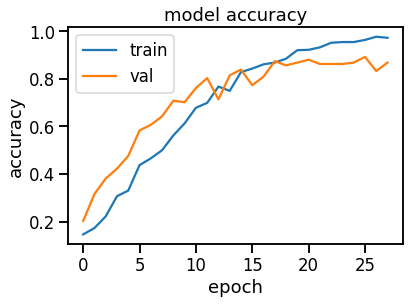

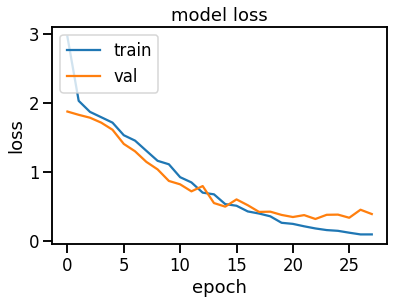

In [433]:
PlotModel(history=history)

In [434]:
model_nlp.evaluate(x=x_test, y=y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 0.6169 - acc: 0.8333


[0.6168650984764099, 0.8333333134651184]

### Images

#### SIFT

Voir Jupyter Notebook

#### Transfer learning

In [454]:
# Transfer learning en utilisant le modèle VGG16

vgg16 = keras.applications.vgg16.VGG16

base_model = vgg16(include_top=False, weights='imagenet', input_shape=(300, 300, 3))

# On gèle les couches inférieures du modèle
for layer in base_model.layers:
    layer.trainable = False    

# Ajout d'un nouveau classifier
flat1 = base_model.layers[-1].output
x = keras.layers.GlobalAveragePooling2D()(flat1)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
output_img = keras.layers.Dense(7, activation='softmax')(x)

model_img = keras.Model(inputs=base_model.inputs, outputs=output_img)

model_img.summary()

Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0  

In [455]:
model_img.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [437]:
def PreprocessingImg(path='/content/drive/MyDrive/colab/P6/Flipkart/Images', list_img= list(df.image)) :
  ### Fonction effectuant le preprocessing nécessaire sur les images ###
  array_img = []

  for img in list_img:
    image = keras.preprocessing.image.load_img(path+ '/' +img, grayscale=False, color_mode="rgb", target_size=[300,300], interpolation="nearest")
    array = keras.preprocessing.image.img_to_array(image)
    array_img.append(array)
  return np.array([array_img])

img_data = PreprocessingImg()

img_array = img_data[0]



/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [456]:
y = df['labels'].astype('category').cat.codes
X_train_img, X_test_img, y_train_img, y_test_img =train_test_split(img_array, y, test_size=0.2, shuffle=True, random_state=0, stratify=y)

In [457]:
# Entraînement du modèle

history_img = model_img.fit(x=X_train_img, y=y_train_img, epochs=50, callbacks=callback, validation_split=0.2, shuffle=True, verbose=2)

Epoch 1/50
21/21 - 27s - loss: 3.7902 - accuracy: 0.5595 - val_loss: 1.9242 - val_accuracy: 0.7321
Epoch 2/50
21/21 - 22s - loss: 0.9328 - accuracy: 0.8125 - val_loss: 1.1476 - val_accuracy: 0.7738
Epoch 3/50
21/21 - 22s - loss: 0.5730 - accuracy: 0.8542 - val_loss: 1.1786 - val_accuracy: 0.7798
Epoch 4/50
21/21 - 22s - loss: 0.3375 - accuracy: 0.8899 - val_loss: 0.9431 - val_accuracy: 0.8155
Epoch 5/50
21/21 - 22s - loss: 0.2584 - accuracy: 0.9345 - val_loss: 1.0300 - val_accuracy: 0.8095
Epoch 6/50
21/21 - 22s - loss: 0.2541 - accuracy: 0.9196 - val_loss: 1.1939 - val_accuracy: 0.7917
Epoch 7/50
21/21 - 22s - loss: 0.1359 - accuracy: 0.9479 - val_loss: 0.9740 - val_accuracy: 0.8274
Epoch 8/50
21/21 - 22s - loss: 0.1102 - accuracy: 0.9583 - val_loss: 1.0335 - val_accuracy: 0.8393
Epoch 9/50
21/21 - 22s - loss: 0.0588 - accuracy: 0.9807 - val_loss: 0.9939 - val_accuracy: 0.8393


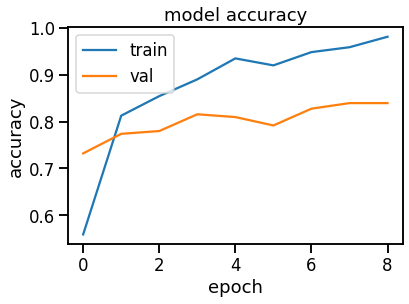

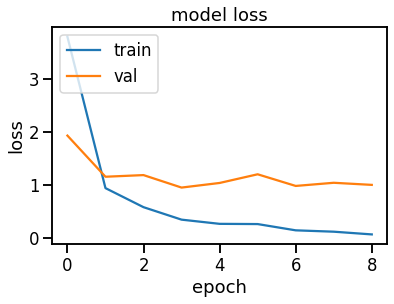

In [458]:
# Visualisation des graphiques d'entraînement du modèle

PlotModel(history=history_img, metric='accuracy', metric_val='val_accuracy', loss='loss',
              val_loss='val_loss')

In [459]:
# Évalutation du modèle sur des nouvelles données 

model_img.evaluate(x=X_test_img, y=y_test_img, batch_size=32, verbose=2)

7/7 - 8s - loss: 1.0348 - accuracy: 0.8143


[1.034764289855957, 0.8142856955528259]

### Multi inputs model

##### Préparation du texte

In [507]:
# Preprocessing du texte

X = list(df['description'])

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_length)
vectorizer.adapt(X)

In [508]:
# Création du corpus

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [509]:
# Matrice d'embedding

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

Converted 4846 words (1858 misses)


In [522]:
y = df['labels'].astype('category').cat.codes
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp =train_test_split(df['description'], y, test_size=0.2, shuffle=True, stratify=y, random_state=2)
_, X_val_nlp, _, y_val_nlp =train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=2)


X_train_nlp = vectorizer(np.array([[s] for s in X_train_nlp])).numpy()
X_val_nlp = vectorizer(np.array([[s] for s in X_val_nlp])).numpy()
X_test_nlp = vectorizer(np.array([[s] for s in X_test_nlp])).numpy()



y_train_nlp = np.array(y_train_nlp)
y_val_nlp = np.array(y_val_nlp)
y_test_nlp = np.array(y_test_nlp)

##### Préparation des images

In [523]:
X_train_img, X_test_img, y_train_img, y_test_img =train_test_split(img_array, y, test_size=0.2, shuffle=True, stratify=y, random_state=2)
_, X_val_img, _, y_val_img =train_test_split(X_train_img, y_train_img, test_size=0.2, shuffle=True, stratify=y_train_img, random_state=2)

In [524]:
# Validation des splits
assert (y_val_img == y_val_nlp).all()
assert (y_test_nlp == y_test_img).all()




##### Modèlisation

In [525]:
# Architecture du modèle multi-inputs

from tensorflow.keras import layers

class_names = df['labels'].unique()

int_nlp = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_nlp)
x = layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(embedded_sequences)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
model_nlp = keras.Model(int_nlp, x)


# load model without classifier layers
img_model = vgg16(include_top=False, weights='imagenet', input_shape=(300, 300, 3))

for layer in img_model.layers:
    layer.trainable = False    

# add new classifier layers
y = layers.Flatten()(img_model.layers[-1].output)
y = layers.Dense(1024, activation='relu')(y)

# define new model
model_img = keras.Model(inputs=img_model.inputs, outputs=y)

concat = keras.layers.concatenate([x, y])

z = layers.Dense(1024, activation="relu")(concat)
z = layers.Dropout(0.5)(z)
z = layers.Dense(len(class_names), activation="softmax")(z)

model_double = keras.Model(inputs=[int_nlp, img_model.input], outputs=z)

model_double.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')


In [526]:
# Résumé

model_double.summary()

Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_69[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [539]:
# Augmentation de la patience

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Entraînement du modèle

history_db = model_double.fit(
	x=[X_train_nlp, X_train_img], y=y_train_nlp,  batch_size=32, epochs=50, verbose='auto',
    callbacks=callback, validation_split=0.2, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=32, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

Epoch 1/50
21/21 [==============================] - 33s 1s/step - loss: 0.5409 - accuracy: 0.9881 - val_loss: 3.9736 - val_accuracy: 0.9524
Epoch 2/50
21/21 [==============================] - 23s 1s/step - loss: 1.1566 - accuracy: 0.9896 - val_loss: 4.9343 - val_accuracy: 0.9464
Epoch 3/50
21/21 [==============================] - 23s 1s/step - loss: 0.8439 - accuracy: 0.9926 - val_loss: 8.2759 - val_accuracy: 0.9286
Epoch 4/50
21/21 [==============================] - 23s 1s/step - loss: 0.6675 - accuracy: 0.9896 - val_loss: 4.7331 - val_accuracy: 0.9464


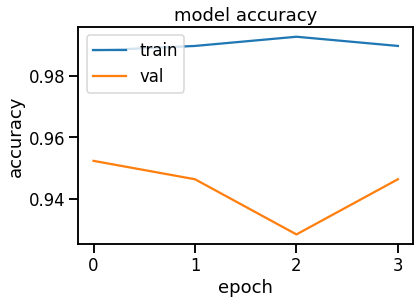

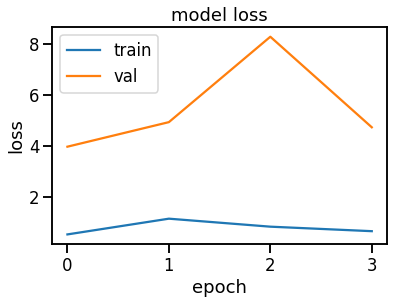

In [540]:
PlotModel(history=history_db, metric='accuracy', metric_val='val_accuracy', loss='loss',
              val_loss='val_loss')

In [541]:
model_double.evaluate(x=[X_test_nlp, X_test_img], y=y_test_nlp, batch_size=32, verbose=2)

7/7 - 8s - loss: 29.8463 - accuracy: 0.8238


[29.846342086791992, 0.8238095045089722]